# Convolutional Neural Networks: Simple Application


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [40]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [41]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Prepare train and test data
X_train = X_train_orig/225
Y_train = np.eye(6)[Y_train_orig.reshape(-1)].T.T
X_test = X_test_orig/225
Y_test = np.eye(6)[Y_test_orig.reshape(-1)].T.T

ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
seed = 3                                          # to keep results consistent (numpy seed)
(m, n_H0, n_W0, n_C0) = X_train.shape             
n_y = Y_train.shape[1]                            
costs = []                                        # To keep track of the cost

 # Create Placeholders of the correct shape
### START CODE HERE ### (1 line)
X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
Y = tf.placeholder(tf.float32, shape=(None, n_y))

# Initialize parameters
tf.set_random_seed(1)
W1 = tf.get_variable("W1",  [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
W2 = tf.get_variable("W2",  [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))    

parameters = {"W1": W1, "W2": W2}

# Forward propagation: Build the forward propagation in the tensorflow graph
# Retrieve the parameters from the dictionary "parameters" 
W1 = parameters['W1']
W2 = parameters['W2']
    
# CONV2D: stride of 1, padding 'SAME'
Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
# RELU
A1 = tf.nn.relu(Z1)
# MAXPOOL: window 8x8, sride 8, padding 'SAME'
P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
# CONV2D: filters W2, stride 1, padding 'SAME'
Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")
# RELU
A2 = tf.nn.relu(Z2)
# MAXPOOL: window 4x4, stride 4, padding 'SAME'
P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
# FLATTEN
P2 = tf.contrib.layers.flatten(P2)
# FULLY-CONNECTED without non-linear activation function (not not call softmax).
# 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)

# Cost function: Add cost function to tensorflow graph
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
        
# Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
learning_rate=0.009
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
# Initialize all the variables globally
init = tf.global_variables_initializer()
num_epochs =100
minibatch_size = 64

Cost after epoch 0: 1.919551
Cost after epoch 5: 1.542004
Cost after epoch 10: 0.882481
Cost after epoch 15: 0.713281
Cost after epoch 20: 0.620813
Cost after epoch 25: 0.578840
Cost after epoch 30: 0.517101
Cost after epoch 35: 0.475654
Cost after epoch 40: 0.469346
Cost after epoch 45: 0.428041
Cost after epoch 50: 0.406183
Cost after epoch 55: 0.410386
Cost after epoch 60: 0.398974
Cost after epoch 65: 0.356391
Cost after epoch 70: 0.370871
Cost after epoch 75: 0.333031
Cost after epoch 80: 0.356059
Cost after epoch 85: 0.307613
Cost after epoch 90: 0.295293
Cost after epoch 95: 0.290434


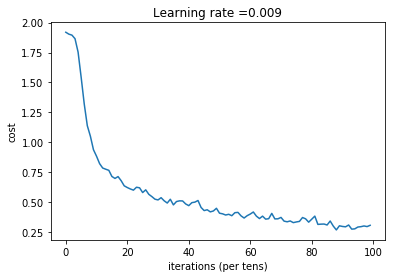

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.907407
Test Accuracy: 0.691667


In [33]:
# Start the session to compute the tensorflow graph
with tf.Session() as sess:
        
    # Run the initialization
    sess.run(init)
        
    # Do the training loop
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
            # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
            minibatch_cost += temp_cost / num_minibatches
                
        # Print the cost every epoch
        if epoch % 5 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
        if epoch % 1 == 0:
            costs.append(minibatch_cost)
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
                